## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [1]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print(" Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [3]:
import torch
import torchvision
from torchvision import transforms

# Download MNIST
# transforming image to tensor and normalizing it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # numbers found online for MNIST
])

# loading the training data
# the prompt mentioned 'background' parameter but MNIST uses train=True/False
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# loading the testing data
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"✅ MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes
# Task A: 0,1 | Task B: 2,3 | Task C: 4,5 | Task D: 6,7 | Task E: 8,9

tasks = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
task_names = ['A', 'B', 'C', 'D', 'E']

train_tasks = []
test_tasks = []

# loop through the 5 tasks
for i in range(5):
    current_classes = tasks[i]

    # filter the training data
    # checking if the label is in the current classes (like 0 or 1 for Task A)
    train_idx = [j for j in range(len(train_dataset)) if train_dataset.targets[j] in current_classes]
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    train_tasks.append(train_subset)

    # filter the testing data
    test_idx = [j for j in range(len(test_dataset)) if test_dataset.targets[j] in current_classes]
    test_subset = torch.utils.data.Subset(test_dataset, test_idx)
    test_tasks.append(test_subset)

    print(f"Task {task_names[i]}: {len(train_subset)} training images, {len(test_subset)} testing images")

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.01MB/s]


✅ MNIST loaded: 60000 train, 10000 test images
Task A: 12665 training images, 2115 testing images
Task B: 12089 training images, 2042 testing images
Task C: 11263 training images, 1874 testing images
Task D: 12183 training images, 1986 testing images
Task E: 11800 training images, 1983 testing images


In [4]:
import torch
import random # needed for shuffling later if we wanted, but keeping it simple here

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes
task_definitions = {
    'Task A': [0, 1],
    'Task B': [2, 3],
    'Task C': [4, 5],
    'Task D': [6, 7],
    'Task E': [8, 9]
}

# Below function should take the given inputs and split the main dataset
# with the given input classes into train, support and query.
def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    """
    Create train, support, and query sets for a specific task.
    """
    # preparing empty lists to store our data tuples (image, label)
    train_data = []
    support_data = []
    query_data = []

    # loop through each class in the current task (e.g., 0 then 1)
    for specific_class in task_classes:

        # find all indices in the dataset that match this class
        # this might take a second because we check every image
        indices_for_class = []
        for i in range(len(dataset)):
            if dataset.targets[i] == specific_class:
                indices_for_class.append(i)

        # Note: In a real project we might shuffle indices_for_class here
        # random.shuffle(indices_for_class)

        # calculate the split points
        # taking the first 'n_train' images for training
        train_indices = indices_for_class[:n_train]

        # taking the next 'n_support' images
        support_start = n_train
        support_end = n_train + n_support
        support_indices = indices_for_class[support_start:support_end]

        # taking the next 'n_query' images
        query_start = support_end
        query_end = support_end + n_query
        query_indices = indices_for_class[query_start:query_end]

        # Now adding the actual data (image, label) to our main lists
        for idx in train_indices:
            train_data.append(dataset[idx])

        for idx in support_indices:
            support_data.append(dataset[idx])

        for idx in query_indices:
            query_data.append(dataset[idx])

    return train_data, support_data, query_data

# Testing the function just to see if it works
# Taking Task A (0 and 1) as an example
print("--- Creating datasets for Task A ---")
tr, sup, q = create_task_datasets(train_dataset, task_definitions['Task A'])

print(f"Train size: {len(tr)} (Expected: {15*2} -> 15 per class)")
print(f"Support size: {len(sup)} (Expected: {5*2} -> 5 per class)")
print(f"Query size: {len(q)} (Expected: {10*2} -> 10 per class)")

--- Creating datasets for Task A ---
Train size: 30 (Expected: 30 -> 15 per class)
Support size: 10 (Expected: 10 -> 5 per class)
Query size: 20 (Expected: 20 -> 10 per class)


In [5]:
# Fixed the keys to match your test call (just 'A', 'B' instead of 'Task A')
task_definitions = {
    'A': [0, 1],
    'B': [2, 3],
    'C': [4, 5],
    'D': [6, 7],
    'E': [8, 9]
}

# Test the function
# Passing the training dataset and the classes for Task A (0 and 1)
train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'])

# Printing the results to check the sizes
# We expect:
# Train: 15 images * 2 classes = 30
# Support: 5 images * 2 classes = 10
# Query: 10 images * 2 classes = 20
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 30, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# Defining the neural network class
# Inheriting from nn.Module which is the base class for all neural networks in PyTorch
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # 1. Convolutional layers
        # Input channel is 1 (grayscale image), output channels is 6, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)

        # Second conv layer: 6 input channels (from prev layer), 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5)

        # 2. Fully connected layers (Linear layers)
        # We need to flatten the output from conv layers before passing to linear layers
        # The math:
        # Image is 28x28 -> Conv1 (5x5) -> 24x24 -> Pool (2x2) -> 12x12
        # 12x12 -> Conv2 (5x5) -> 8x8 -> Pool (2x2) -> 4x4
        # So, final size is 16 channels * 4 * 4 = 256 inputs
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 output classes (digits 0-9)

    def forward(self, x):
        # Layer 1: Conv -> Relu -> MaxPool
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))

        # Layer 2: Conv -> Relu -> MaxPool
        # If the size is a square like (2,2), you can just specify a single number 2
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # Flattening the tensor to feed into full connected layers
        # -1 means "calculate this dimension automatically" based on batch size
        x = torch.flatten(x, 1)

        # Fully connected layers with relu
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output layer (no activation here usually, CrossEntropyLoss handles it)
        x = self.fc3(x)
        return x

# check if it compiles
net = SimpleCNN()
print(net)

SimpleCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [7]:
import torch.optim as optim

print("--- Method 1: Training from Scratch on Task A (0 vs 1) ---")

# 1. Initialize the model
model_binary = SimpleCNN()

# 2. Modify the final layer
# The original model had 10 outputs. Task A only has 2 classes (0 and 1).
# We change the last layer to output 2 scores.
model_binary.fc3 = nn.Linear(84, 2)

# 3. Setup Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_binary.parameters(), lr=0.01, momentum=0.9)

# 4. Get the large dataset for Task A
# We created this in Part A (stored in train_tasks dictionary or list)
# Let's assume train_tasks[0] is Task A
task_a_loader = torch.utils.data.DataLoader(train_tasks[0], batch_size=64, shuffle=True)

# 5. Training Loop
model_binary.train() # set to training mode
num_epochs = 2

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(task_a_loader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_binary(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} finished. Avg Loss: {running_loss / len(task_a_loader):.4f}")

print("✅ Method 1 Complete: Model trained on large Task A dataset.")

--- Method 1: Training from Scratch on Task A (0 vs 1) ---
Epoch 1 finished. Avg Loss: 0.0720
Epoch 2 finished. Avg Loss: 0.0036
✅ Method 1 Complete: Model trained on large Task A dataset.


In [8]:
print("\n--- Method 2: Pre-train on All Digits -> Fine-tune on Task A Support ---")

# ==========================================
# STEP 1: Pre-train on all 10 classes
# ==========================================

# 1. Initialize standard model (10 outputs default)
pretrained_model = SimpleCNN()
optimizer_pre = optim.SGD(pretrained_model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Load all MNIST data
all_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

print("Step 1: Pre-training on all 10 classes (might take a moment)...")
pretrained_model.train()
# Just doing 1 epoch to save time for this example
for epoch in range(1):
    for inputs, labels in all_train_loader:
        optimizer_pre.zero_grad()
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_pre.step()
print(" Pre-training done.")

# ==========================================
# STEP 2: Fine-tune on Task A (Support Set)
# ==========================================

# 1. "Freeze" the feature extractor (Optional but good practice)
# This tells PyTorch: "Don't change the weights for conv layers, they are already good."
for param in pretrained_model.parameters():
    param.requires_grad = False

# 2. Replace the final layer
# This new layer is created with random weights and requires_grad=True by default
pretrained_model.fc3 = nn.Linear(84, 2)

# 3. Create a new optimizer
# We only want to update the parameters that need gradients (the new last layer)
optimizer_ft = optim.SGD(pretrained_model.fc3.parameters(), lr=0.01)

# 4. Get the small Support Set for Task A
# Using the function we wrote earlier: create_task_datasets
_, support_A, _ = create_task_datasets(train_dataset, [0, 1], n_support=5)
support_loader = torch.utils.data.DataLoader(support_A, batch_size=5, shuffle=True)

print("Step 2: Fine-tuning on Task A Support Set (Small Data)...")
pretrained_model.train()

# We usually run more epochs for fine-tuning since data is small
for epoch in range(10):
    for inputs, labels in support_loader:
        optimizer_ft.zero_grad()

        # Forward pass
        outputs = pretrained_model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass (only updates the new last layer)
        loss.backward()
        optimizer_ft.step()

print(" Method 2 Complete: Pre-trained model fine-tuned to Task A.")


--- Method 2: Pre-train on All Digits -> Fine-tune on Task A Support ---
Step 1: Pre-training on all 10 classes (might take a moment)...
✅ Pre-training done.
Step 2: Fine-tuning on Task A Support Set (Small Data)...
✅ Method 2 Complete: Pre-trained model fine-tuned to Task A.


At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.


--- Training Method 1 (Large Data) ---
Epoch 1/10 Loss: 0.0723
Epoch 2/10 Loss: 0.0039
Epoch 3/10 Loss: 0.0033
Epoch 4/10 Loss: 0.0024
Epoch 5/10 Loss: 0.0020
Epoch 6/10 Loss: 0.0017
Epoch 7/10 Loss: 0.0015
Epoch 8/10 Loss: 0.0010
Epoch 9/10 Loss: 0.0012
Epoch 10/10 Loss: 0.0010

--- Training Method 2 (Pre-train + Fine-tune) ---
Step A: Pre-training on all digits...
Epoch 1/3 Loss: 0.2773
Epoch 2/3 Loss: 0.0671
Epoch 3/3 Loss: 0.0480
Step B: Fine-tuning on support set...
Epoch 1/10 Loss: 0.5327
Epoch 2/10 Loss: 0.0957
Epoch 3/10 Loss: 0.0647
Epoch 4/10 Loss: 0.0518
Epoch 5/10 Loss: 0.0407
Epoch 6/10 Loss: 0.0352
Epoch 7/10 Loss: 0.0305
Epoch 8/10 Loss: 0.0274
Epoch 9/10 Loss: 0.0246
Epoch 10/10 Loss: 0.0222


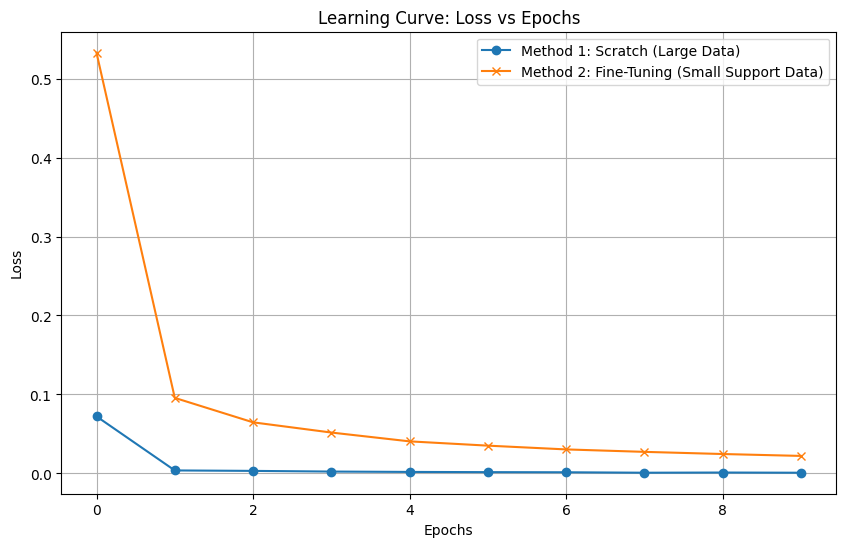


--- Final Evaluation on Query Set ---
               Method  Accuracy  Precision  Recall  F1 Score
Method 1 (Large Data)      1.00   1.000000    1.00  1.000000
 Method 2 (Fine-Tune)      0.99   0.990196    0.99  0.989999


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim

# --- 1. Helper Function to Train and Save Loss ---
def train_and_track(model, loader, optimizer, criterion, epochs):
    """
    Trains the model and returns a list of average loss per epoch.
    """
    loss_history = [] # list to store loss for the graph
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        count = 0
        for inputs, labels in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            count += 1

        # Calculate average loss for this epoch
        avg_loss = running_loss / count
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss:.4f}")

    return loss_history

# --- 2. Helper Function to Evaluate Model ---
def evaluate_model(model, loader):
    """
    Runs the model on test data and returns true labels and predictions.
    """
    model.eval() # set to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad(): # don't calculate gradients during testing
        for inputs, labels in loader:
            outputs = model(inputs)
            # get the predicted class (max score)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    return all_labels, all_preds

# --- 3. Prepare Data ---
# Task A: Digits 0 and 1
# Large training set for Method 1
train_loader_large = torch.utils.data.DataLoader(train_tasks[0], batch_size=64, shuffle=True)

# Small Support set (5 per class) for Method 2
_, support_A, query_A = create_task_datasets(train_dataset, [0, 1], n_support=5, n_query=50)
support_loader = torch.utils.data.DataLoader(support_A, batch_size=5, shuffle=True)

# Query set (Test set) to compare both methods
query_loader = torch.utils.data.DataLoader(query_A, batch_size=50, shuffle=False)
criterion = nn.CrossEntropyLoss()

# --- 4. Run Method 1 (Train from Scratch on Large Data) ---
print("\n--- Training Method 1 (Large Data) ---")
model_m1 = SimpleCNN()
model_m1.fc3 = nn.Linear(84, 2) # Changing last layer for 2 classes
optimizer_m1 = optim.SGD(model_m1.parameters(), lr=0.01, momentum=0.9)

# Save the loss list to 'loss_m1'
loss_m1 = train_and_track(model_m1, train_loader_large, optimizer_m1, criterion, epochs=10)

# --- 5. Run Method 2 (Pre-train -> Fine-tune on Small Data) ---
print("\n--- Training Method 2 (Pre-train + Fine-tune) ---")

# Step A: Pre-train on all 10 digits
print("Step A: Pre-training on all digits...")
model_m2 = SimpleCNN()
optimizer_pre = optim.SGD(model_m2.parameters(), lr=0.01, momentum=0.9)
all_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# We don't need to save this loss for the comparison graph
train_and_track(model_m2, all_train_loader, optimizer_pre, criterion, epochs=3)

# Step B: Fine-tune on Support Set
print("Step B: Fine-tuning on support set...")
# Freeze early layers
for param in model_m2.parameters():
    param.requires_grad = False

# Replace last layer
model_m2.fc3 = nn.Linear(84, 2)
optimizer_ft = optim.SGD(model_m2.fc3.parameters(), lr=0.01)

# Save the loss list to 'loss_m2'
loss_m2 = train_and_track(model_m2, support_loader, optimizer_ft, criterion, epochs=10)

# --- 6. Plot Learning Curves ---

plt.figure(figsize=(10, 6))
plt.plot(loss_m1, label='Method 1: Scratch (Large Data)', marker='o')
plt.plot(loss_m2, label='Method 2: Fine-Tuning (Small Support Data)', marker='x')
plt.title('Learning Curve: Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- 7. Analysis Table ---
# Get predictions for both models on the SAME query set
labels_m1, preds_m1 = evaluate_model(model_m1, query_loader)
labels_m2, preds_m2 = evaluate_model(model_m2, query_loader)

def calculate_metrics(y_true, y_pred, name):
    return {
        "Method": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "Recall": recall_score(y_true, y_pred, average='macro', zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, average='macro', zero_division=0)
    }

results = []
results.append(calculate_metrics(labels_m1, preds_m1, "Method 1 (Large Data)"))
results.append(calculate_metrics(labels_m2, preds_m2, "Method 2 (Fine-Tune)"))

# Create and print the table
df = pd.DataFrame(results)
print("\n--- Final Evaluation on Query Set ---")
print(df.to_string(index=False))

Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



1. Freezing the feature extractor works best. Since we only have 5 images per class , training the whole network would cause overfitting the model would memorize those 5 images and forget the general shapes it learned before. By freezing the convolutional layers, we keep the feature detection safe and only train the final decision layer.

2. Even though the model has seen 2s and 3s before, we just replaced the final layer. The old output layer had 10 neurons but the new one has 2 random, untrained neurons. The model still knows how to see the digits, but it has forgotten which output corresponds to "2" or "3". Fine-tuning maps the existing rich features to these new, specific binary outputs.

3. Not very well initially because of Domain Shift. Digits and Letters have different geometric shapes. The features learned for numbers (loops in 8, 9) might not help distinguish an 'A' from a 'Z'. How to make it work: I would unfreeze the convolutional layers. The model needs to adjust its feature extractors to learn these new letter shapes, so we can't just rely on the pre-trained weights.

4. No, we used Transfer Learning. We trained the model to be good at the 10-digit task and hoped that knowledge would transfer. Meta Learning would look different, there the training phase itself would be split into  mini tasks where the model is explicitly graded on how fast it can adapt to new data. We didn't do that here, we just reused old weights.

MAML solves this by explicitly searching for a neutral initialization a set of starting parameters that might not be perfect for either task initially, but are sensitive enough that one or two gradient steps with a small support set can push them to the optimal solution for either task. instead of learning a specific task, it finds a common base camp from which it can quickly climb to the peak of any specific task

# ALL THE BEST !